In [1]:
import sys
sys.path.insert(0, '../')
from lib.io_functions import load_npy, save_proccesed_variables
from lib.fit_functions import fit_wvfs,scfunc, gauss
from lib.sim_functions import rand_scint_times
from lib.wvf_functions import find_baseline_cuts, find_amp_decrease
from lib.dec_functions import deconvolve

import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 15})


*** THIS NOTEBOOK REQUIRES SPE_DEC TO BE RUN FIRST IN ORDER TO GENERATE TEMPLATE AND RELATED PARAMETERS ***

In [2]:
# Load wvf template 
my_run = load_npy([0],[0],"Analysis_","../data/ana/")

MC_num = 1000 # Number of mc wvf to be generated
buffer = 2000  # Buffer expanding array to accomodate scint wvfs [ticks]

my_run[0][0]["McADC"] = []
my_run[0][0]["Mct0"] = []
for i in range(MC_num):
    times = rand_scint_times(100,fast=6e-9,slow=1.4e-6,ratio=0.7)                  # Main mc function generates photon arrival times
    wvf = np.zeros(my_run[0][0]["PreSignal"]+buffer+my_run[0][0]["PostSignal"])

    for t in times:
        this_peak = int((t-(t%my_run[0][0]["Sampling"]))/my_run[0][0]["Sampling"]) # Calculate the modulus of the arrival time according to sampling.
        # peaks.append(this_peak)
        this_wvf = np.zeros(my_run[0][0]["PreSignal"]+this_peak)
        this_wvf = np.append(this_wvf,my_run[0][0]["FitSCSPE"][0])
        this_wvf = np.append(this_wvf,np.zeros(len(wvf)-len(this_wvf)))            # If this line gives errors, make buffer bigger
        wvf = wvf+this_wvf
    my_run[0][0]["McADC"].append(wvf)
    my_run[0][0]["Mct0"].append(times[0])
    
my_run[0][0]["Mct0"] = np.asarray(my_run[0][0]["Mct0"])
my_run[0][0]["McNoiseADC"] = np.asarray(my_run[0][0]["McADC"])+np.random.normal(0,np.max(my_run[0][0]["ADC"])*0.5,size=[len(my_run[0][0]["McADC"]),len(my_run[0][0]["McADC"][0])])

my_run[0][0]["FitSC"] = []
my_run[0][0]["FitSC"].append(scfunc(np.arange(len(my_run[0][0]["McNoiseADC"][0])),*my_run[0][0]["FitParam"]))
i_fit_thrld_idx,f_fit_thrld_idx = find_amp_decrease(my_run[0][0]["FitSC"][0],1e-4)
my_run[0][0]["FitSC"][0] = np.roll(my_run[0][0]["FitSC"][0],-i_fit_thrld_idx)



Loaded Analysis_run with keys: dict_keys(['NRun', 'NChannel', 0])
-----------------------------------------------


In [3]:
OPT = {
    "NOISE_AMP": 0.5, # Noise amp as a factor of SPE max.
    "FIX_EXP":True,
    "WIENER_BUFFER": 200,
    "CONVERT_ADC": False
    }

OPT["FILTER"] = "WIENER"
KEY = ["McADC","FitSC","DecADC"]
deconvolve(my_run,my_run,my_run,KEY,OPT)

KEY = ["McNoiseADC","FitSC","DecNoiseADC"]
deconvolve(my_run,my_run,my_run,KEY,OPT)

OPT["FILTER"] = "GAUSS"
KEY = ["McADC","FitSC","DecADC"]
deconvolve(my_run,my_run,my_run,KEY,OPT)

KEY = ["McNoiseADC","FitSC","DecNoiseADC"]
deconvolve(my_run,my_run,my_run,KEY,OPT)


Generated wvfs with key WienerDecADC
Generated wvfs with key WienerDecNoiseADC
Generated wvfs with key GaussDecADC
Generated wvfs with key GaussDecNoiseADC


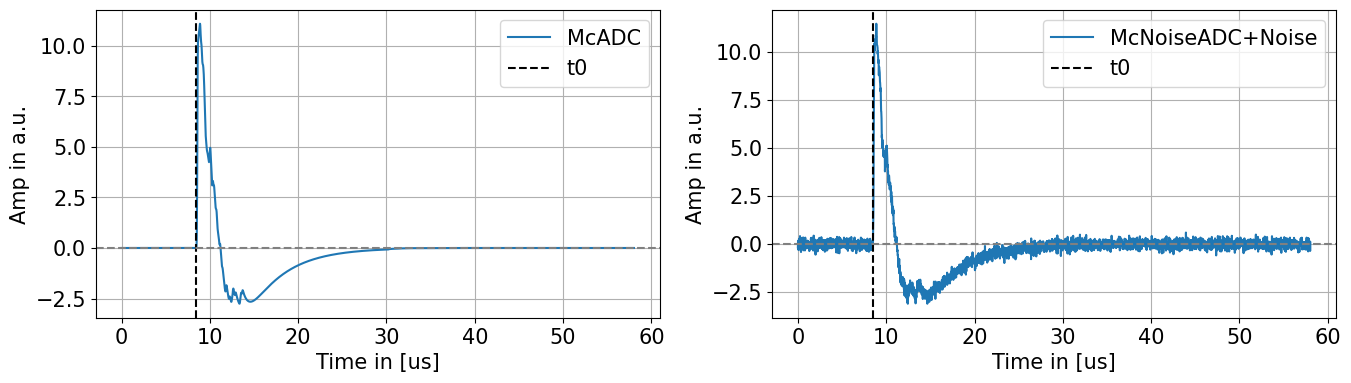

In [6]:
num = np.random.randint(0,MC_num)

single_wvf_label = ["McADC","McNoiseADC"]; color = "tab:blue"
# single_wvf_label = ["GaussDecADC","GaussDecNoiseADC"]; color = "tab:green"
# single_wvf_label = ["WienerDecADC","WienerDecNoiseADC"]; color = "tab:orange"

i_base_idx,f_base_idx = find_baseline_cuts(my_run[0][0][single_wvf_label[0]][num])
ave_wvf = np.mean(my_run[0][0][single_wvf_label[0]],axis=0)

fig, ax = plt.subplots(1,2,figsize=(16,4))

ax[0].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][single_wvf_label[0]][num])),my_run[0][0][single_wvf_label[0]][num],label=single_wvf_label[0],c=color)
# ax[0].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["McADC"][num])),scfunc(np.arange(len(my_run[0][0]["McADC"][num])),*param),c="tab:orange",label="MC TEMPLATE")

ax[1].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][single_wvf_label[1]][num])),my_run[0][0][single_wvf_label[1]][num],label="%s+Noise"%single_wvf_label[1],c=color)
# ax[1].axvline(1e6*my_run[0][0]["Sampling"]*i_base_idx,ls="--",color="grey",label="BaselineCut")
# ax[1].axvline(1e6*my_run[0][0]["Sampling"]*f_base_idx,ls="--",color="grey")
# ax[1].axvline(1e6*my_run[0][0]["Sampling"]*np.argmax(my_run[0][0]["McNoiseADC"][num]),c="black",label="RISE TIME: %.2f"%(1e6*my_run[0][0]["Sampling"]*(np.argmax(my_run[0][0]["McNoiseADC"][num])-i_base_idx)))
# ax[1].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["McNoiseADC"][num])),scfunc(np.arange(len(my_run[0][0]["McNoiseADC"][num])),*my_run[0][0]["FitParam"]),c="tab:orange",label="MC TEMPLATE")

for i in range(len(ax)):
    # ax[i].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(ave_wvf)),ave_wvf,c="k",alpha=.5,label="Ave%s"%single_wvf_label[0])
    ax[i].axvline(1e6*my_run[0][0]["Sampling"]*(2*my_run[0][0]["PreSignal"] + 1)+1e3*my_run[0][0]["Mct0"][num],color="k",ls="--",label="t0")
    ax[i].set_xlabel("Time in [us]")
    ax[i].set_ylabel("Amp in a.u.")
    ax[i].axhline(0,c="grey",ls="--")
    ax[i].legend()
    # ax[i].set_xlim([8,12])
    ax[i].grid(True)
plt.show()

Fitting wvf  0


Fitting wvf  0




/home/smanthey/Code/CYTHON_TOOLS/notebooks/../lib/fit_functions.py:44: RuntimeWarning: overflow encountered in exp
  return (2 * a/tau)*np.exp((sigma/(np.sqrt(2)*tau))**2-(np.array(t)-t0)/tau)*(1-erf((sigma**2-tau*(np.array(t)-t0))/(np.sqrt(2)*sigma*tau)))
/home/smanthey/Code/CYTHON_TOOLS/notebooks/../lib/fit_functions.py:44: RuntimeWarning: overflow encountered in multiply
  return (2 * a/tau)*np.exp((sigma/(np.sqrt(2)*tau))**2-(np.array(t)-t0)/tau)*(1-erf((sigma**2-tau*(np.array(t)-t0))/(np.sqrt(2)*sigma*tau)))
/home/smanthey/Code/CYTHON_TOOLS/notebooks/../lib/fit_functions.py:44: RuntimeWarning: invalid value encountered in multiply
  return (2 * a/tau)*np.exp((sigma/(np.sqrt(2)*tau))**2-(np.array(t)-t0)/tau)*(1-erf((sigma**2-tau*(np.array(t)-t0))/(np.sqrt(2)*sigma*tau)))


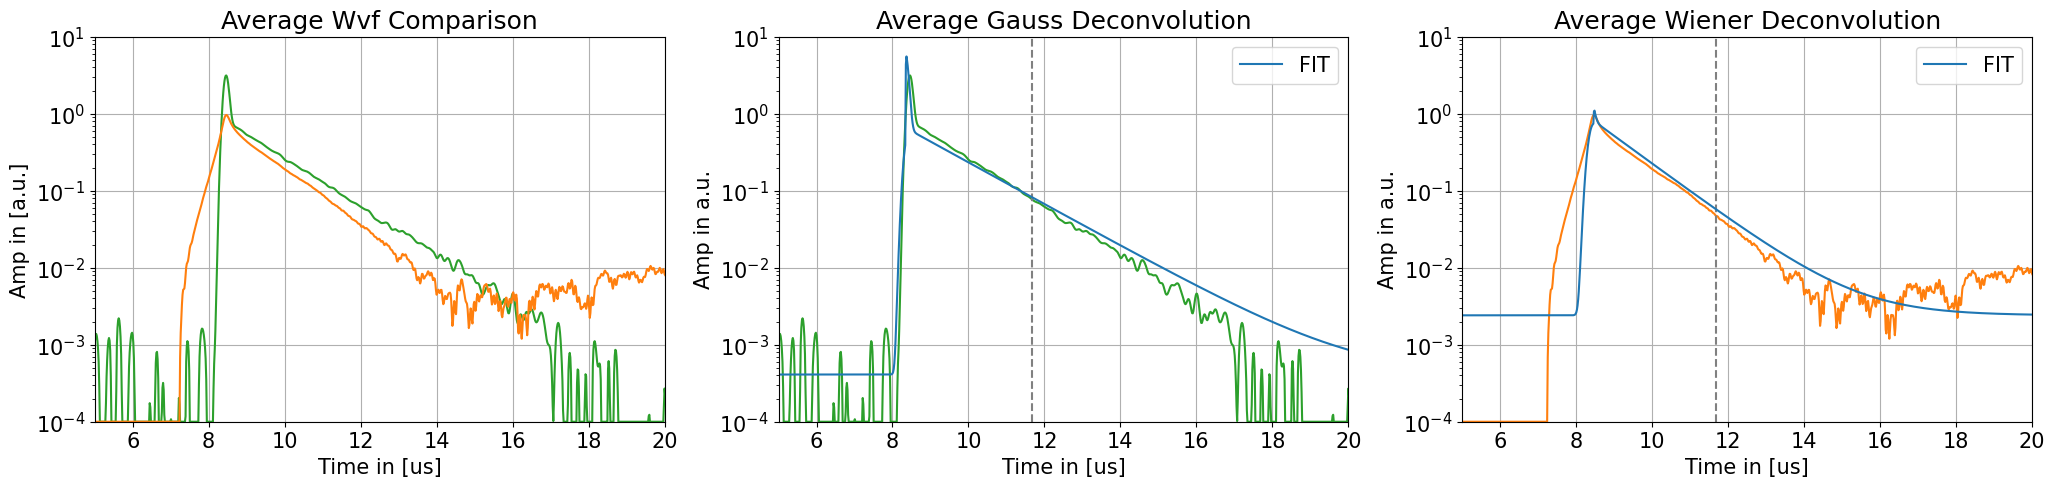

In [7]:
opt = {"SHOW": False,
       "LOGY": True,
       "TERMINAL_OUTPUT": False
}

filter_key = ["Gauss","Wiener"]
dec_key = ["GaussDecNoiseADC","WienerDecNoiseADC"]
color = ["tab:green","tab:orange"]

for ii in range(len(dec_key)):
    my_run[0][0]["Ave"+dec_key[ii]] = []
    my_run[0][0]["Ave"+dec_key[ii]].append(np.mean(my_run[0][0][dec_key[ii]],axis=0))
    i_idx, f_idx = find_baseline_cuts(my_run[0][0]["Ave"+dec_key[ii]][0])   
    my_run[0][0]["ILimitAve"+filter_key[ii]] = i_idx
    my_run[0][0]["FLimitAve"+filter_key[ii]] = f_idx
    fit_wvfs(my_run,"Scint",1e-4,fit_range=[my_run[0][0]["PreTrigger"],200],sigma = 5e-9, a_fast = 2e-7,a_slow = 3e-7,in_key=["Ave"+dec_key[ii]],out_key=dec_key[ii],OPT = opt)

fig,ax = plt.subplots(1,3,figsize=(25,5))
for i in range(len(ax)-1):
    ax[0].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["Ave"+dec_key[i]][0])),my_run[0][0]["Ave"+dec_key[i]][0],c=color[i],label=dec_key[i])
    ax[i+1].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["Ave"+dec_key[i]][0])),my_run[0][0]["Ave"+dec_key[i]][0],c=color[i])
    ax[i+1].axvline(1e6*my_run[0][0]["Sampling"]*(np.argmax(my_run[0][0]["Ave"+dec_key[i]][0])+200),ls="--",c="grey")
    ax[i+1].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["FitScint"+dec_key[i]][0])),my_run[0][0]["FitScint"+dec_key[i]][0],label="FIT")
    ax[i+1].semilogy()
    ax[i+1].set_ylim([1e-4,1e1]) 
    ax[i+1].set_xlabel("Time in [us]")
    ax[i+1].set_ylabel("Amp in a.u.")
    ax[i+1].axhline(0,c="grey",ls="--")
    ax[i+1].grid(True)
    ax[i+1].set_xlim([5,20])
    ax[i+1].legend()
ax[0].grid(True)
ax[0].set_xlim([5,20])
ax[0].set_ylim([1e-4,1e1])
ax[0].semilogy()
ax[0].set_ylabel("Amp in [a.u.]")
ax[0].set_xlabel("Time in [us]")
ax[0].set_title("Average Wvf Comparison")
ax[1].set_title("Average Gauss Deconvolution")
ax[2].set_title("Average Wiener Deconvolution")
plt.show()

In [8]:
raw_key = ["McNoiseADC","GaussDecNoiseADC","WienerDecNoiseADC"]
wvf_key = ["Raw","Gauss","Wiener"]

for j in range(len(raw_key)):
    my_run[0][0][wvf_key[j]+"Charge"] = []
    my_run[0][0][wvf_key[j]+"Amp"] = []
    my_run[0][0][wvf_key[j]+"Time"] = [] 
    my_run[0][0][wvf_key[j]+"NoiseSTD"] = [] 
    for i in range(len(my_run[0][0][raw_key[j]])):
        i_base_idx,f_base_idx = find_baseline_cuts(my_run[0][0][raw_key[j]][i])
        amp = np.max(my_run[0][0][raw_key[j]][i])
        time = my_run[0][0]["Sampling"]*(np.argmax(my_run[0][0][raw_key[j]][i])-2*my_run[0][0]["PreSignal"] + 1) - my_run[0][0]["Mct0"][i]
        noiseSTD = np.std(my_run[0][0][raw_key[j]][i][:i_base_idx])
        if raw_key[j] == "McNoiseADC":
            charge = np.sum(my_run[0][0][raw_key[j]][i][i_base_idx:f_base_idx])
            my_run[0][0][wvf_key[j]+"Charge"].append(my_run[0][0]["Sampling"]*charge/my_run[0][0]["SPEChargeADC"]) 
        else:
            charge = np.sum(my_run[0][0][raw_key[j]][i][:my_run[0][0]["FLimitAveGauss"]])
            my_run[0][0][wvf_key[j]+"Charge"].append(charge)
        my_run[0][0][wvf_key[j]+"Amp"].append(amp)
        my_run[0][0][wvf_key[j]+"Time"].append(time*1e9)
        my_run[0][0][wvf_key[j]+"NoiseSTD"].append(noiseSTD)
    my_run[0][0][wvf_key[j]+"Charge"]   = np.asarray(my_run[0][0][wvf_key[j]+"Charge"])
    my_run[0][0][wvf_key[j]+"Amp"]      = np.asarray(my_run[0][0][wvf_key[j]+"Amp"])
    my_run[0][0][wvf_key[j]+"Time"]     = np.asarray(my_run[0][0][wvf_key[j]+"Time"])
    my_run[0][0][wvf_key[j]+"NoiseSTD"] = np.asarray(my_run[0][0][wvf_key[j]+"NoiseSTD"])

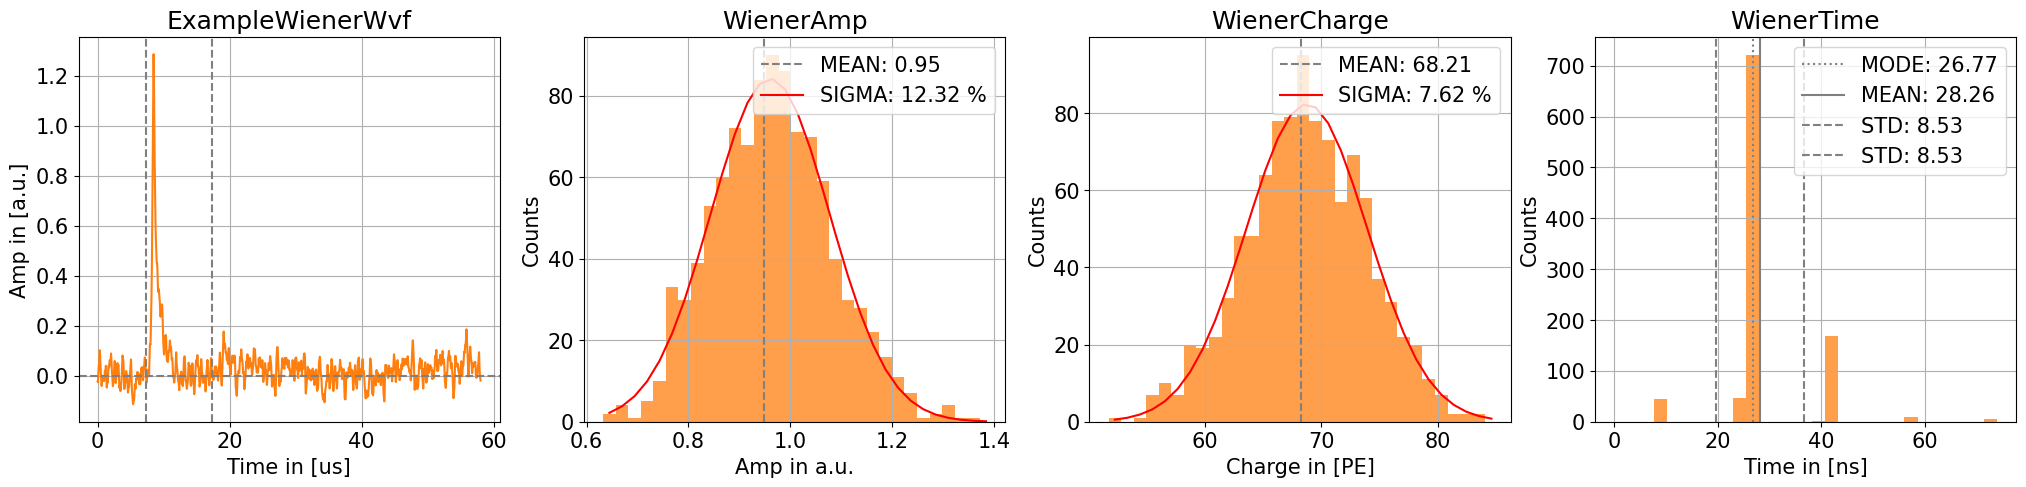

In [11]:
# %matplotlib qt
dec_key = "DecNoiseADC"
sigma = [1,50,1e-9]
num = np.random.randint(0,MC_num)

# filter_key = "Raw"; color = "tab:blue"
# filter_key = "Gauss"; color = "tab:green"
filter_key = "Wiener"; color = "tab:orange"

key_value = [filter_key+"Amp",filter_key+"Charge",filter_key+"Time"]
x_label = ["Amp in a.u.","Charge in [PE]","Time in [ns]"]

fig,ax = plt.subplots(1,4,figsize=(25,5))
if filter_key == "Raw":
    # t0_bins = np.arange(0,np.max(my_run[0][0][key_value[i-1]]),16)
    ax[0].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["McNoiseADC"][num])),my_run[0][0]["McNoiseADC"][num],c="tab:blue",label="MC NOISE",alpha=.75)

else:
    # t0_bins = np.arange(0,np.max(my_run[0][0][key_value[i-1]]),2)
    ax[0].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][filter_key+dec_key][num])),my_run[0][0][filter_key+dec_key][num],c=color,label="MC NOISE")
    ax[0].axvline(1e6*my_run[0][0]["ILimitAve"+filter_key]*my_run[0][0]["Sampling"],c="grey",ls="--")
    ax[0].axvline(1e6*my_run[0][0]["FLimitAveGauss"]*my_run[0][0]["Sampling"],c="grey",ls="--")

for i in range(1,len(ax)):
    if i == 1 or i == 2 :
        n,bins,patches = ax[i].hist(my_run[0][0][key_value[i-1]],bins=30,alpha=0.75,color=color)
        initial = [np.max(n)*sigma[i-1],bins[np.argmax(n)+1],sigma[i-1]]
        gauss_fit_labels = ["Amp:\t","Mean:\t","Sigma:\t"]
        try:
            popt2, pcov2 = curve_fit(gauss,bins[:-1],n,p0=initial)
        except:
            print("FIT COULD NOT BE PERFORMED"); popt2 = initial
        # for j in range(len(popt2)): print(gauss_fit_labels[j],"{:.2E}".format(popt2[j]))
        # if i == 2: print("#PE: %.2f"%(popt2[1]/my_run[0][0]["SPECharge"]))
        ax[i].axvline(popt2[1],c="grey",ls="--",label="MEAN: %.2f"%abs(popt2[1]))
        ax[i].plot(bins+(bins[1]-bins[0])/2,gauss(bins,*popt2),c="red",label="SIGMA: %.2f %%"%abs(100*popt2[2]/popt2[1]))

    else:
        # n,bins,patches = ax[i].hist(my_run[0][0][key_value[i-1]],bins=t0_bins,alpha=0.75,color=color)
        n,bins,patches = ax[i].hist(my_run[0][0][key_value[i-1]],bins=np.linspace(0,np.max(my_run[0][0][key_value[i-1]]),30),alpha=0.75,color=color)
        ax[i].axvline(bins[np.argmax(n)]+bins[1]/2,c="grey",ls=":",label="MODE: %.2f"%(bins[np.argmax(n)]+bins[1]/2))
        ax[i].axvline(np.mean(my_run[0][0][key_value[i-1]]),c="grey",label="MEAN: %.2f"%np.mean(my_run[0][0][key_value[i-1]]))
        ax[i].axvline(np.mean(my_run[0][0][key_value[i-1]])+np.std(my_run[0][0][key_value[i-1]]),c="grey",ls="--",label="STD: %.2f"%np.std(my_run[0][0][key_value[i-1]]))
        ax[i].axvline(np.mean(my_run[0][0][key_value[i-1]])-np.std(my_run[0][0][key_value[i-1]]),c="grey",ls="--",label="STD: %.2f"%np.std(my_run[0][0][key_value[i-1]]))
    
    ax[i].legend()
    ax[i].set_title(key_value[i-1])
    ax[i].set_xlabel(x_label[i-1])
    ax[i].set_ylabel("Counts")
    ax[i].grid(True,which="both")

ax[0].grid(True)
ax[0].axhline(0,ls="--",c="grey")
ax[0].set_title("Example" + filter_key + "Wvf")
ax[0].set_xlabel("Time in [us]")
ax[0].set_ylabel("Amp in [a.u.]")
plt.show()